In [1]:
import pickle as pkl
import torch
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import entropy

In [2]:
data_path = r"../data/pickles/50_salads_unified.pkl"

In [3]:
with open(data_path, "rb") as f:
    data = pkl.load(f)

det, sto = data['target'], data['stochastic']

In [4]:
def average_entropy_sequence(seq):
    return np.mean([entropy(x) for x in seq])

def average_entropy_data(data):
    return np.mean([average_entropy_sequence(x) for x in data])

In [6]:
average_entropy_data(det), average_entropy_data(sto)

(0.0, 0.24932393)

In [6]:
def get_beta_params(low, high, middle):
    """
    Determines Beta parameters such that when sampling X ~ Beta(a, b)
    and scaling alpha = low + (high - low) * X, we have P(alpha < 0.5) ≈ middle.
    Here we fix a = 1 and solve for b.

    Parameters:
      low    : lower bound of the target range.
      high   : upper bound of the target range.
      middle : desired probability that alpha is less than 0.5.

    Returns:
      (a, b) : tuple of Beta parameters.
    """
    a = 1.0
    q = (0.5 - low) / (high - low)
    b = np.log(1 - middle) / np.log(1 - q)
    return a, b

def sample_concentration_parameter(low=0.05, high=1, middle=0.8):
    """
    Samples a concentration parameter α in [low, high] such that
    P(α < 0.5) ≈ 0.8.
    """
    a, b = get_beta_params(low, high, middle)
    x = np.random.beta(a, b)
    # Scale to [low, high]
    alpha = low + (high - low) * x
    return alpha

def add_dirichlet_noise(p, alpha=0.1, noise_level=0.1):
    """
    p: original probability vector (e.g., one-hot)
    alpha: concentration parameter for the Dirichlet distribution.
           Lower alpha makes the Dirichlet sample more "peaky".
    noise_level: mixing coefficient for the noise.
    """
    # Generate a Dirichlet noise vector.
    noise = np.random.dirichlet(np.ones_like(p) * alpha)
    # Mix the original distribution with the noise.
    perturbed = (1 - noise_level) * p + noise_level * noise
    # Ensure it sums to 1.
    perturbed /= perturbed.sum()
    return perturbed

In [9]:
alphas = [sample_concentration_parameter() for _ in range(100)]
alphas

[0.16291009049881994,
 0.11188667623158186,
 0.3176241982862078,
 0.1985066913872211,
 0.8595098459009421,
 0.36253901013745854,
 0.6069829578548479,
 0.4015340100674773,
 0.25390750859789196,
 0.45130083925168907,
 0.16990708734002524,
 0.3635700645992577,
 0.21769243219550677,
 0.6091568928846216,
 0.06868137953579402,
 0.33450159218157327,
 0.28730186709309397,
 0.09120464885829016,
 0.27603573435540174,
 0.2209664461838447,
 0.20838801605475987,
 0.146104922200572,
 0.2625771205067195,
 0.14677778989195284,
 0.28180956186619605,
 0.24680980224617272,
 0.09020992447636222,
 0.2810400724517601,
 0.47429183081565857,
 0.25514722473679463,
 0.5790026549246181,
 0.20369502783271154,
 0.4164793929530544,
 0.4206366104933326,
 0.7181672292521897,
 0.36266032222845274,
 0.16341996251676863,
 0.2986575279686908,
 0.45873096077812164,
 0.09146458394209092,
 0.1765449783748732,
 0.34002838252204387,
 0.2528043735996869,
 0.10428917642697062,
 0.16012854878941668,
 0.09117805732154086,
 0.0555

In [24]:
for trace in det:
    alphas = [sample_concentration_parameter() for _ in range(trace.shape[0])]
    noisy_trace = [add_dirichlet_noise(event, alpha, 0.2) for event, alpha in zip(trace, alphas)]
    break
noisy_trace

[array([1.34466497e-09, 4.34589705e-19, 1.31660737e-06, 7.61665222e-05,
        2.23283107e-02, 1.66567058e-08, 5.70778507e-07, 7.70069596e-05,
        1.58007045e-03, 1.32705866e-02, 9.45156533e-04, 8.46758669e-13,
        6.36749386e-02, 1.51692740e-04, 2.13791036e-08, 3.77055014e-03,
        6.61647868e-02, 8.03561971e-01, 2.43968360e-02]),
 array([8.14966709e-03, 2.74703622e-04, 4.68326956e-02, 8.87936512e-07,
        3.47008751e-03, 1.02250104e-05, 8.47416685e-02, 1.01691566e-03,
        6.36428713e-05, 1.45043340e-02, 9.20357804e-03, 1.36648369e-02,
        9.15430185e-04, 7.47182160e-04, 3.39477689e-03, 3.18008238e-03,
        6.33262955e-03, 8.03458581e-01, 3.80751142e-05]),
 array([2.36856276e-05, 5.70355516e-03, 2.32869100e-02, 1.05761441e-02,
        2.01766685e-02, 6.25717306e-03, 6.46930604e-03, 3.57897900e-03,
        1.54475037e-02, 1.82248047e-03, 1.44674039e-03, 8.76080935e-03,
        1.30617823e-02, 5.69407324e-03, 1.81173782e-02, 1.17865769e-02,
        1.50272857e-

In [26]:
noisy_trace = np.array(noisy_trace)

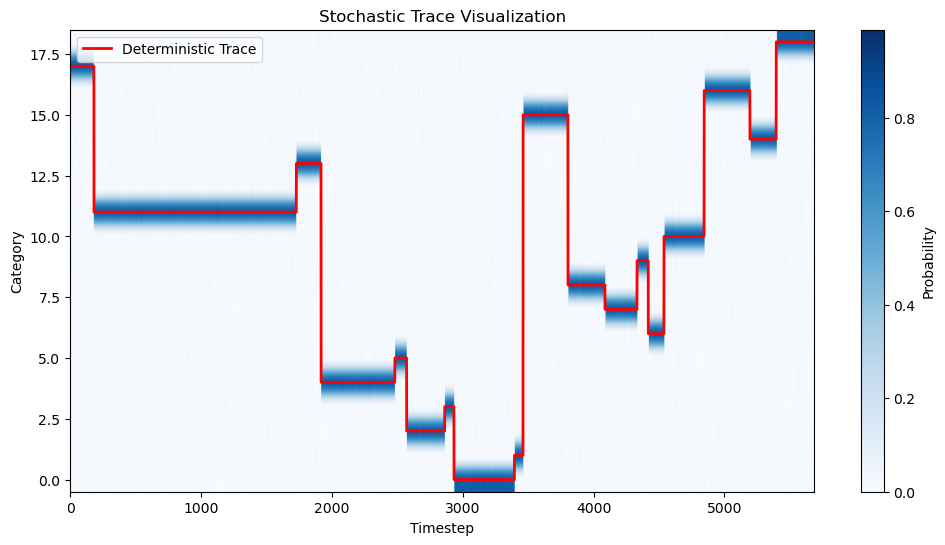

In [27]:
import matplotlib.pyplot as plt

# Plot heatmap using Matplotlib
fig, ax = plt.subplots(figsize=(12, 6))
cax = ax.imshow(noisy_trace.T, aspect='auto', cmap='Blues', origin='lower')

# Overlay deterministic trace
ax.plot(np.arange(noisy_trace.shape[0]), np.argmax(noisy_trace, axis=1), color='red', linestyle='solid', linewidth=2, label='Deterministic Trace')

# Labels and colorbar
ax.set_xlabel("Timestep")
ax.set_ylabel("Category")
ax.set_title("Stochastic Trace Visualization")
fig.colorbar(cax, label="Probability")
ax.legend()

plt.show()